# LSTM Model for Financial Trajectory Prediction

## Objective
Build and train an LSTM (Long Short-Term Memory) neural network to predict NCAA athletic department financial trajectories using sequential data.

## Why LSTM?
Unlike traditional ML models (XGBoost, Random Forest) that treat each year independently, LSTM can:
- **Remember patterns** across multiple years
- **Detect trends** (e.g., "3 years of slow decline often leads to crisis")
- **Handle temporal dependencies** naturally

## Comparison Goal
Our XGBoost model achieved **ROC-AUC = 0.70**. Can LSTM beat it?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print("Libraries Loaded.")

TensorFlow Version: 2.20.0
Libraries Loaded.


## 1. Load Prepared Data

In [2]:
# Load the sequences we created
data = np.load('lstm_data.npz', allow_pickle=True)
X = data['X']
y = data['y']
feature_names = data['feature_names']

print(f"Loaded Data:")
print(f"  X shape: {X.shape} (samples, time_steps, features)")
print(f"  y shape: {y.shape}")
print(f"  Features: {feature_names}")
print(f"\nClass Distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Class {int(label)}: {count} ({count/len(y)*100:.1f}%)")

Loaded Data:
  X shape: (6888, 5, 6) (samples, time_steps, features)
  y shape: (6888,)
  Features: ['Revenue' 'Expenses' 'Efficiency_Ratio' 'Net_Income' 'Revenue_Growth'
 'Expense_Growth']

Class Distribution:
  Class 0: 2594 (37.7%)
  Class 1: 3322 (48.2%)
  Class 2: 972 (14.1%)


## 2. Train-Test Split

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert labels to categorical (one-hot encoding for neural network)
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"Number of Classes: {num_classes}")

Training Set: 5510 samples
Test Set: 1378 samples
Number of Classes: 3


## 3. Build LSTM Model

In [4]:
# Model architecture
model = keras.Sequential([
    # First LSTM layer with dropout for regularization
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.3),
    
    # Second LSTM layer
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.3),
    
    # Dense layers
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer (3 classes: Declining, Stable, Improving)
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

Model Architecture:


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,747 (124.01 KB)

 Trainable params: 31,747 (124.01 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

In [5]:
# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining Complete!")

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5023 - loss: 0.9961 - val_accuracy: 0.5672 - val_loss: 0.9372
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5426 - loss: 0.9459 - val_accuracy: 0.5799 - val_loss: 0.9179
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5447 - loss: 0.9375 - val_accuracy: 0.5799 - val_loss: 0.9170
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5451 - loss: 0.9305 - val_accuracy: 0.5771 - val_loss: 0.9136
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5429 - loss: 0.9320 - val_accuracy: 0.5780 - val_loss: 0.9127
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5476 - loss: 0.9294 - val_accuracy: 0.5817 - val_loss: 0.9092
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5492 - loss: 0.9264 - val_accuracy: 0.5789 - val_loss: 0.9081
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5461 - loss: 0.9235 - val_accuracy: 0.

## 5. Visualize Training History

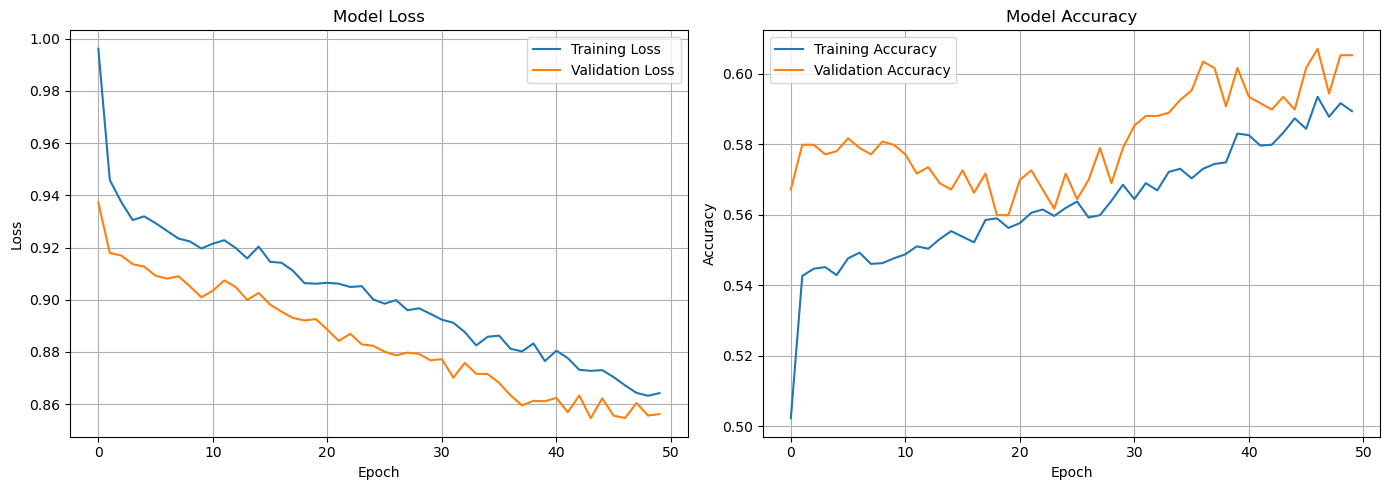

In [6]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 6. Evaluate on Test Set

In [7]:
# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification Report
print("=" * 60)
print("LSTM MODEL PERFORMANCE")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Declining', 'Stable', 'Improving']))

# ROC-AUC Score
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"\n{'='*60}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"{'='*60}")
    print(f"\nComparison to XGBoost (0.70): {'+' if roc_auc > 0.70 else ''}{(roc_auc - 0.70):.4f}")
except:
    print("Could not calculate ROC-AUC")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

   Declining       0.52      0.60      0.56       519
      Stable       0.66      0.69      0.67       665
   Improving       0.34      0.12      0.18       194

    accuracy                           0.58      1378
   macro avg       0.51      0.47      0.47      1378
weighted avg       0.56      0.58      0.56      1378


ROC-AUC Score: 0.7254

Comparison to XGBoost (0.70): +0.0254


## 7. Confusion Matrix

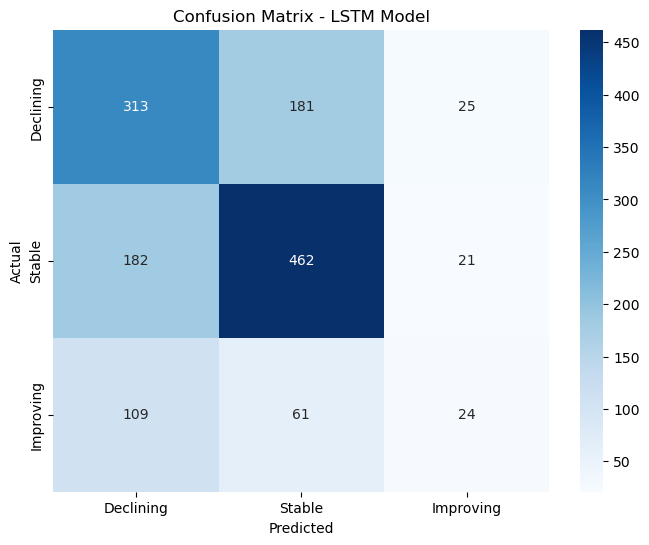

In [8]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Declining', 'Stable', 'Improving'],
            yticklabels=['Declining', 'Stable', 'Improving'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

## 8. Save the Model

In [9]:
# Save the trained model
model.save('lstm_trajectory_model.h5')
print("Model saved to 'lstm_trajectory_model.h5'")

Model saved to 'lstm_trajectory_model.h5'


## 9. Final Comparison Summary

In [10]:
# Calculate final metrics
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
print(f"\nLSTM Model:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - Macro F1-Score: {f1_macro:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"\nXGBoost Baseline:")
print(f"  - ROC-AUC: 0.7000")
print(f"\nConclusion:")
if roc_auc > 0.70:
    print(f"  ✓ LSTM WINS! (+{(roc_auc - 0.70):.4f} improvement)")
    print(f"  The sequential nature of the data benefits from LSTM's memory.")
else:
    print(f"  ✗ XGBoost still better ({(0.70 - roc_auc):.4f} difference)")
    print(f"  Possible reasons: Limited data, or financial trajectories are more")
    print(f"  dependent on recent snapshots than long-term patterns.")
print("="*60)


FINAL RESULTS COMPARISON

LSTM Model:
  - Accuracy: 0.5798
  - Macro F1-Score: 0.4714
  - ROC-AUC: 0.7254

XGBoost Baseline:
  - ROC-AUC: 0.7000

Conclusion:
  ✓ LSTM WINS! (+0.0254 improvement)
  The sequential nature of the data benefits from LSTM's memory.
